# Notebook model et itérations

## Sommaire

## Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import requests
from PIL import Image
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.utils.np_utils import to_categorical
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import itertools

#Setting the Theme of the data visualizer Seaborn
sns.set(style="dark",context="notebook",palette="muted")

In [2]:
#data_train.head()

In [3]:
#y = data_train['label']
#X = data_train.drop('label', axis=1)

## Fonctions

#### Visulation d'image

In [4]:
def viz_num(num,X,y):
    #Reshape the 768 values to a 28x28 image
    image = X.values[num].reshape([28,28])
    plt.title('Sample: %d  Label: %d' % (num, y[num]))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

#### Import de données

In [5]:
def modify_data():
    #Les données que nous voulons :
    global y, X, X_train, X_test, y_train, y_test, input_shape, test_size
    #Rentrer les chemins des fichiers :
    print("Veuillez entrer le chemin du fichier d'entraînement ('train.csv' de base)")
    chemin_1=input()
    print("Veuillez entrer le chemin du fichier de test ('test.csv' de base)")
    chemin_2=input()
    #Import des données
    data_train = pd.read_csv(chemin_1)
    data_test = pd.read_csv(chemin_2)
    #Séparation label/dataset
    y = data_train['label']
    X = data_train.drop('label', axis=1)
    #Encoding des labels
    y = tf.keras.utils.to_categorical(y, num_classes=10)
    # Splitting du dataset pour le training, on peut changer le test size et random_state en appelant la fonction
    print("Quel sera la répartition train/test ? (test_size : 0.1, 0.2, 0.3, 0.33...)")
    test_size=float(input())
    print("Quel sera la seed choisit aléatoirement ? (random_state)")
    random_state=int(input())
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    # Reshaping des images
    X_train = X_train.values.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.values.reshape(X_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)
    #Changement du type des données
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    #Scaling (normalisation) des données
    X_train /= 255
    X_test /= 255


#### Modèle

In [6]:
def model():
    #Variables que nous voulons garder
    global history, model, couches, applatissements, lr, dropout, epochs, patience, batch_size, validation_split
    
    # Creating a Sequential Model and adding the layers
    model = Sequential()
    print("Combien de couches convolutionnelles et de pooling voulez vous dans le modèle ?")
    couches=int(input())
    
    for i in range(couches):
            couche_conv_pool()
    print("Combien d'opération d'applatissement voulez vous ?")
    applatissements=int(input())
    for i in range(applatissements):
            flatten()
    print("Choisissez le taux de Dropout (0.1, 0.15, 0.2...)")
    dropout=float(input())
    model.add(Dropout(dropout))
    model.add(Dense(10,activation=tf.nn.softmax))
    print("Sélectionnez le learning rate (0.01, 0.03, 0.001, 0.003...)")
    lr=float(input())
    opt = Adam(learning_rate=lr)
    model.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
    print("Combien d'epoch voulez vous ?")
    epochs = int(input())
    print("Pour l'early stopping, à partir de combien d'epoch voulez vous vous arrêter si aucune amélioration n'a lieu ?")
    patience=int(input())
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
    print("De combien sera la batch size ?")
    batch_size = int(input())
    print("Et de combien sera la validation split ?")
    validation_split= float(input())
    history = model.fit(x=X_train,y=y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[es])
    
    model.evaluate(X_test, y_test)
    model.summary()

#### Les différentes couches du modèle 

In [7]:
def couche_conv_pool():
    global filtres
    print("Entrer le nombre de filtres pour cette couche de convolution")
    filtres=int(input())
    print("Entrer la taille du kernel, si 3 -> dimension [3,3], si 5 -> dimension [5,5]...")
    dimension=int(input())
    model.add(Conv2D(filtres, kernel_size=(dimension,dimension), input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

In [8]:
def flatten():
    model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
    print("Combien voulez vous de cases applati ?")
    cases=int(input())
    model.add(Dense(cases, activation=tf.nn.relu))

#### Le rapport

In [9]:
def rapport():
    global y_test, y_pred, history, model
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_test = np.argmax(y_test, axis=1)
    plot_curve1()
    plot_curve2()
    class_report()
    conf_matrix()

In [10]:
def plot_curve1():
    global history, test_size, couches, applatissements, lr, dropout, epochs, patience, batch_size, validation_split
    test_size=str(test_size)
    couches=str(couches)
    applatissements=str(applatissements)
    lr=str(lr)
    dropout=str(dropout)
    epochs=str(epochs)
    patience=str(patience)
    batch_size=str(batch_size)
    validation_split=str(validation_split)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(str(r'C:\Users\Simplon\Desktop\Travaux python\CNN exercice data\Image stats modèles\curve1 test_size = '+test_size+'couches = '+couches+' flattening = '+applatissements+' dropout = '+dropout+' lr = '+lr+' epochs = '+epochs+' patience = '+patience+' batch size = '+batch_size+' validation_split = '+validation_split+'.png'), dpi=300)
    return plt.show()

In [11]:
 def plot_curve2():
    global history, test_size, couches, applatissements, lr, dropout, epochs, patience, batch_size, validation_split
    test_size=str(test_size)
    couches=str(couches)
    applatissements=str(applatissements)
    lr=str(lr)
    dropout=str(dropout)
    epochs=str(epochs)
    patience=str(patience)
    batch_size=str(batch_size)
    validation_split=str(validation_split)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig(str(r'C:\Users\Simplon\Desktop\Travaux python\CNN exercice data\Image stats modèles\curve2  test_size = '+test_size+'couches = '+couches+' flattening = '+applatissements+' dropout = '+dropout+' lr = '+lr+' epochs = '+epochs+' patience = '+patience+' batch size = '+batch_size+' validation_split = '+validation_split+'.png'), dpi=300)
    return plt.show()

In [12]:
def class_report():
    global y_test, y_pred
    print(classification_report(y_test, y_pred))

In [13]:
def conf_matrix():
    global y_test, y_pred, test_size, couches, applatissements, lr, dropout, epochs, patience, batch_size, validation_split

    test_size=str(test_size)
    couches=str(couches)
    applatissements=str(applatissements)
    lr=str(lr)
    dropout=str(dropout)
    epochs=str(epochs)
    patience=str(patience)
    batch_size=str(batch_size)
    validation_split=str(validation_split)
    cm = confusion_matrix(y_pred, y_test)
    p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual labels')
    plt.xlabel('Predicted labels')
    plt.savefig(str(r'C:\Users\Simplon\Desktop\Travaux python\CNN exercice data\Image stats modèles\conf_matrix test_size = '+test_size+'couches = '+couches+' flattening = '+applatissements+' dropout = '+dropout+' lr = '+lr+' epochs = '+epochs+' patience = '+patience+' batch size = '+batch_size+' validation_split = '+validation_split+'.png'), dpi=300)
    return plt.show()

### Fitting des données 

En appelant la fonction *modify_data* on modifie le shape, normalise et split les données pour le training.

Il faut bien penser à rentrer les **deux chemins** pour les jeux de données "train" et "test", **test_size** et le **random_state**

In [14]:
modify_data()

Veuillez entrer le chemin du fichier d'entraînement ('train.csv' de base)
train.csv
Veuillez entrer le chemin du fichier de test ('test.csv' de base)
test.csv
Quel sera la répartition train/test ? (test_size : 0.1, 0.2, 0.3, 0.33...)
0.2
Quel sera la seed choisit aléatoirement ? (random_state)
2


## EDA

In [15]:
#plt.figure(figsize=(15,7))
#g = sns.countplot(y, palette="icefire")
#plt.title("Number of digit classes")
#y.value_counts()

In [16]:
#y.shape

## Entraînement du modèle

Lancer la ligne de code ci-dessous pour chpoisir les paramètres de votre modèle

In [17]:
model()

Combien de couches convolutionnelles et de pooling voulez vous dans le modèle ?
3
Entrer le nombre de filtres pour cette couche de convolution
8
Entrer la taille du kernel, si 3 -> dimension [3,3], si 5 -> dimension [5,5]...
3
Entrer le nombre de filtres pour cette couche de convolution
16
Entrer la taille du kernel, si 3 -> dimension [3,3], si 5 -> dimension [5,5]...
3
Entrer le nombre de filtres pour cette couche de convolution
32
Entrer la taille du kernel, si 3 -> dimension [3,3], si 5 -> dimension [5,5]...
3
Combien d'opération d'applatissement voulez vous ?
2
Combien voulez vous de cases applati ?
256
Combien voulez vous de cases applati ?
512
Choisissez le taux de Dropout (0.1, 0.15, 0.2...)
0.1
Sélectionnez le learning rate (0.01, 0.03, 0.001, 0.003...)
0.0001
Combien d'epoch voulez vous ?
100
Pour l'early stopping, à partir de combien d'epoch voulez vous vous arrêter si aucune amélioration n'a lieu ?
10
De combien sera la batch size ?
64
Et de combien sera la validation split 

## Rapport du modèle

Lancer la fonction suivante permet d'afficher les différentes performances du modèle, afin de l'évaluer et de comparer à d'autres essais.

*(Nous allons travailler sur la possibilité d'enregistrer les images et les mettres dans un fichier)*

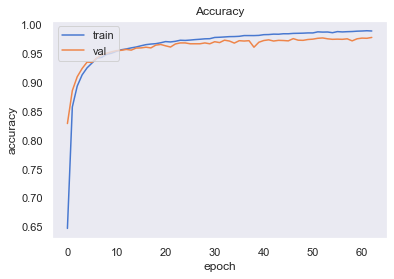

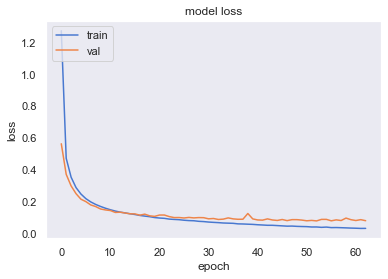

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       821
           1       0.99      0.99      0.99       962
           2       0.97      0.97      0.97       829
           3       0.98      0.97      0.98       864
           4       0.98      0.97      0.98       856
           5       0.97      0.97      0.97       729
           6       0.97      0.98      0.98       839
           7       0.97      0.98      0.97       873
           8       0.96      0.98      0.97       793
           9       0.97      0.96      0.96       834

    accuracy                           0.98      8400
   macro avg       0.98      0.98      0.98      8400
weighted avg       0.98      0.98      0.98      8400



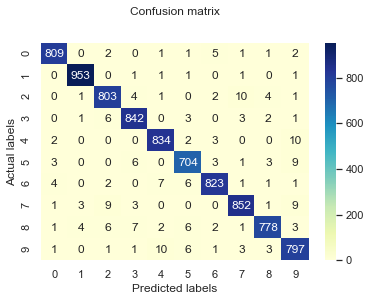

In [18]:
rapport()

In [19]:
model.save("first_model.h5")